In [20]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import joblib
from sklearn.preprocessing import LabelEncoder

## IMPORT FILES TO TRANSFORM
pres_gdp = pd.read_csv("president_gdp-94.csv")
pres_terms = pd.read_csv("president_terms-94.csv",encoding="UTF-8") 

# input the testing feature to predict  
input = 'Name'

## EXPAND YEAR OF TERMS PER LINE
# Create a new DataFrame that will contain the expanded rows
expanded_rows = []

# Iterate over each row and duplicate the data for each year between Start and Stop
for i, row in pres_terms.iterrows():
    for year in range(row['Start'], row['Stop']):
        row_data = row.to_dict()  # Convert row to a dictionary
        row_data['Year'] = year   # Add the expanded year to the dictionary
        expanded_rows.append(row_data)


#Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

## MERGE the two data frames on year
expanded_df = pd.merge(expanded_df,pres_gdp, on = "Year")


# Set index to 'Year' and select columns for categorical_df
categorical_df = expanded_df[['Year','Name', 'VP','BDay', 'Party','sign', 'BMonth', 'GDP Growth', 'Population Growth']].set_index('Year')

# Select numerical columns for numerical_df
numerical_df = expanded_df[['Year','GDP Percent Growth', 'Population Percent Growth']].set_index('Year')

# # Dummify (one-hot encode) The categoricals
# categorical_df = pd.get_dummies(categorical_df)
# Label encode the categorical columns (without one-hot encoding)
label_encoders = {}
for column in categorical_df.columns:  # Loop through each column in categorical_df
    le = LabelEncoder()
    categorical_df[column] = le.fit_transform(categorical_df[column])
    label_encoders[column] = le

# Merge categorical and numerical dataframes
processed_df = pd.merge(categorical_df, numerical_df, left_index=True, right_index=True)

# Exclude the columns in y from dummy_df3
y = processed_df[[input]]

# Define the target columns (y)
X = processed_df.loc[:, ~processed_df.columns.isin(y.columns)]

# Split the preprocessed data into a training and testing dataset -- choose to stratify so that the classes are more balanced out bc it's a small dataset and imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=42)

# Create a StandardScaler instance
scaler = StandardScaler()

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize a multi-output classifier with logistic regression
classifier = LogisticRegression()

# Fit the logistic regression model on the training data
classifier.fit(X_train_scaled, y_train)

# Example input for a birthday on June 12th
input_data = pd.DataFrame({
    'Name': [5],     
    'VP': [7],    
    'BDay': [12], 
    'Party': [0],
    'sign': [3],
    'BMonth': [6], 
    'GDP Growth': [0], 
    'Population Growth': [1],
    'GDP Percent Growth': [3], 
    'Population Percent Growth': [1],
})

# Dynamically drop the column specified by the `input` variable
input_data_for_model = input_data.drop(columns=[input])

# Scale the input data using the same scaler
input_scaled = scaler.transform(input_data_for_model)

# Make the prediction
prediction = classifier.predict(input_scaled)

# Define categorical columns by listing the columns from the categorical_df
categorical_columns = list(categorical_df.columns)

# Check if the `input` is in the list of categorical columns
if input in categorical_columns:
    # Convert the encoded prediction back to the original label (for categorical features)
    predicted_val = label_encoders[input].inverse_transform([prediction[0]])  # Convert label back to original
    print(f"The most likely {input} is: {predicted_val[0]}")
else:
    # For numerical features, directly print the predicted value
    print(f"The most likely {input} is: {prediction[0]}")

The most likely Name is: George Washington


c:\Users\19727\Anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score is 0.8958333333333334
                     feature  importance
3                       sign    1.472080
4                     BMonth    1.107263
7         GDP Percent Growth    0.672483
0                         VP    0.583854
2                      Party    0.491875
5                 GDP Growth    0.235455
1                       BDay    0.168007
8  Population Percent Growth    0.117461
6          Population Growth    0.021442
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         1
          10

c:\Users\19727\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\19727\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\19727\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\19727\Anacon

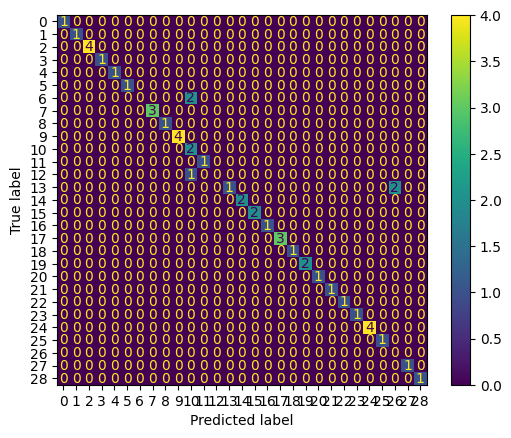

In [21]:
# Make predictions on the test data
y_pred = classifier.predict(X_test_scaled)

## Create accuracy score
accuracy_score(y_true= y_test, y_pred= y_pred)
print(f"Accuracy score is {accuracy_score(y_true= y_test, y_pred= y_pred)}")

## Create Confusion Matrix 
cm_df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred))
disp.plot()


## Display which features are most important 
# Get the absolute values of the coefficients
abs_importances = abs(classifier.coef_[0])  # Get the coefficients from the trained Logistic Regression model

# Create a DataFrame with feature names and their corresponding importances
df_importance = pd.DataFrame({
    'feature': X_train.columns,  # assuming X_train is a DataFrame
    'importance': abs_importances  # use absolute value of coefficients
})

# Sort the DataFrame by importance (descending order)
df_importance = df_importance.sort_values(by='importance', ascending=False)

# Display the top 10 most important features (absolute importance)
print(df_importance.head(10))

# Print the classification report for the model
print(classification_report(y_true = y_test, y_pred = y_pred))

# # Save the trained model directly using joblib
# joblib.dump(classifier, '{input}_multi.pkl')

# print(f"'Model has been saved to '{input}_multi.pkl'")